# Random guided sequence generator

In [5]:
from datetime import date
from pycltools.pycltools import jprint

jprint('Adrien Leger / EMBL EBI', bold=True, size=150)
jprint('Starting date : 2019_02_12', bold=True, italic=True, size=125)
jprint('Last modification date : {}_{:02}_{:02}'.format(date.today().year, date.today().month, date.today().day), bold=True, italic=True, size=125)

## Imports

In [6]:
# Standard lib imports
import os
from datetime import date
from collections import *
from random import *
from glob import glob, iglob
from shutil import rmtree
import itertools
from pprint import pprint as pp
import gzip

# Generic third party imports
from pycltools.pycltools import *
import pysam
import pyfaidx
from tqdm import trange, tqdm
from skbio.alignment import StripedSmithWaterman
from skbio import DNA

# Ploting lib imports
import matplotlib.pyplot as pl
import seaborn as sns
%matplotlib inline

# Data wrangling lib imports
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200

## Generate a random guided reference set 

**The function randomly picks a kmer based on weight equals to the inverse of the representation of each possible kmer in the previously generated sequences**

In [7]:
def random_guided_weight (fasta_fn, alphabet=["A","G","T","C"], kmer_len=7, hp_max=4, seq_len=500, n_seq=100, seed=None):
    
    np.random.seed(seed)
    kmer_c = Counter()
    with open (fasta_fn, "w") as fasta_fp:
        for seq_num in trange(n_seq):
            seq = []

            # First base
            hp = 1
            seq.append(random.choice(alphabet))

            # Extend seed to length kmer_len
            for i in range(kmer_len-1):
                # Reduce choice if max homopolymer reached
                choices = [i for i in alphabet if i!=seq[-1]] if hp >= hp_max else alphabet
                # Sample from available choices
                seq.append(random.choice(choices))
                # Check if homopolymers extends
                hp = hp+1 if seq[-2] == seq[-1] else 1
            kmer_c["".join(seq)] += 1

            # Extend sequence
            for _ in range (seq_len-kmer_len):
                count_d = defaultdict(list)
                prev = seq[-kmer_len+1:]

                # Reduce choice if max homopolymer reached
                choices = [i for i in alphabet if i!=seq[-1]] if hp >= hp_max else alphabet    

                # Collect count for each possible kmers and transform to weights
                p = []
                for b in choices:
                    kmer = "".join(prev+[b])
                    if not kmer in kmer_c:
                        p.append(0)
                    else:
                        p.append(kmer_c[kmer])
                p = np.array(p)
                p = 1/(p-p.min()+1)
                p = p/p.sum()

                # Choose randomly fron base kmer with lower count 
                b = np.random.choice(choices, p=p)
                seq.append(b)
                # Update kmer counter
                kmer_c["".join(prev+[b])] += 1
                # Check if homopolymers extends
                hp = hp+1 if seq[-2]==seq[-1] else 1
            
            # Write to disk
            fasta_fp.write(">ref_{:04}\n{}\n".format(seq_num, "".join(seq)))

In [5]:
fa = "./random_guided_weight.fa"
random_guided_weight(fa, kmer_len=9, hp_max=5, seq_len=500, n_seq=2000, seed=42)
head(fa, max_char_col=100, max_char_line=100)

100%|██████████| 2000/2000 [01:13<00:00, 27.15it/s]

>ref_0000                                                                                           ...
GTCTCAAAAGCTTAAACTTACCAAAGTGGTAGGGCATTATAACCCGATGAGACGTGTTACCCCTCAAAGGGCGGTACACCAACTTCAGACTGAGGTTCGA...
>ref_0001                                                                                           ...
TTTATTGGTTGAGGTACCTTGCTACCCTTGCCAAGCCATGCCCGGGACCCCTCCCAGACTATTGATTCTCTTCGAACTTAAAGTGGCGTCGTCCACGGGC...
>ref_0002                                                                                           ...
GTAGCCGAAAATGTGACCTGTGACACGATCTCTTCAGACCATCATCATGCCCGCCGCATAAATGTAGTCGTCTAACACTCCCGCGGTCCCGGTAAGGGAA...
>ref_0003                                                                                           ...
GTGATCCATGGTCCCGCATAGGGTGGAGAATTTGGCTGAGGGTTTCCTCAAATCACACGAGGGGCTGTTGGAATATTATGCGCTATCTCCAATGCCGACG...
>ref_0004                                                                                           ...
GTAAGCCCTTTAGGAACGTGCGGCCACGGAATGGTCATACTCAAGGACAGCGCAGAACATGGCA

**Plot occurrence distribution of different kmer sizes**

In [8]:
def plot_kmer_content (fasta_fn, min_kmer=5, max_kmer=9):
    with pyfaidx.Fasta(fasta_fn) as fa:
        for kmer_len in range(min_kmer,max_kmer+1):
            jprint (f"Kmer of length {kmer_len}", bold=True)
            c = Counter()
            l = []
            for seq in fa:
                seq = str(seq)
                for i in range(0, len(seq)-kmer_len+1):
                    c[seq[i:i+kmer_len]]+=1       
            print ("Found {:,} kmers out of {:,} possibilities ({:.2f}%)".format(len(c), pow(4,kmer_len), len(c)/pow(4,kmer_len)*100))

            l = []
            for i in c.values():
                l.append(i)
            print ("Median occurences: {:,}, Min occurences: {:,}, Max occurences: {:,}".format(int(np.median(l)),np.min(l),np.max(l)))

            # Bin kmer occurence counts
            cc = Counter()
            for i in c.values():
                cc[i]+=1

            with pl.style.context("ggplot"):
                fig, ax = pl.subplots(figsize=(15,2))
                ax.bar(list(cc.keys()), list(cc.values()))
                ax.set_yscale("log")
                ax.set_xlabel("Occurences count (log scale)")
                pl.show()

Found 1,024 kmers out of 1,024 possibilities (100.00%)
Median occurences: 970, Min occurences: 714, Max occurences: 1,032


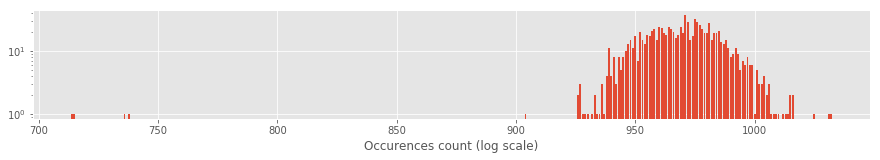

Found 4,092 kmers out of 4,096 possibilities (99.90%)
Median occurences: 242, Min occurences: 213, Max occurences: 278


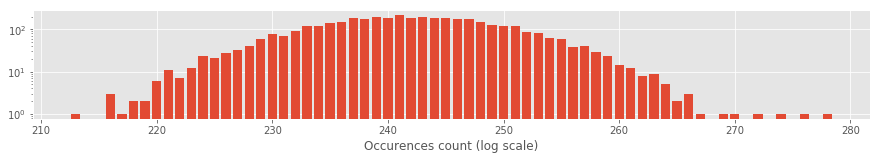

Found 16,356 kmers out of 16,384 possibilities (99.83%)
Median occurences: 60, Min occurences: 44, Max occurences: 88


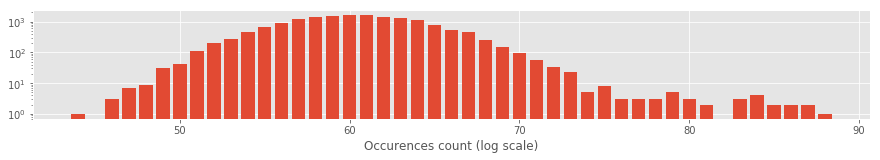

Found 65,376 kmers out of 65,536 possibilities (99.76%)
Median occurences: 15, Min occurences: 7, Max occurences: 28


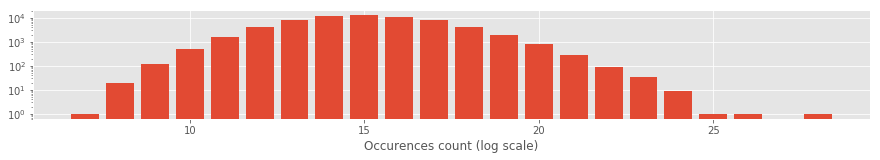

Found 261,257 kmers out of 262,144 possibilities (99.66%)
Median occurences: 4, Min occurences: 1, Max occurences: 9


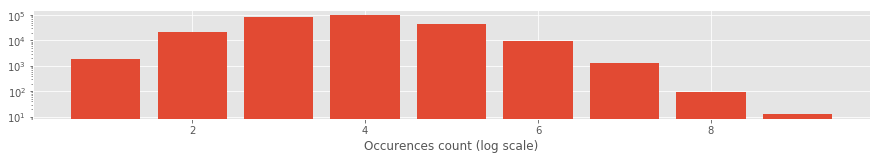

In [9]:
fa = "./random_guided_weight.fa"
plot_kmer_content (fa, min_kmer=5, max_kmer=9)

## Test if sequence are sufficiently different from each other

Pairwise comparison of all sequences generated using a Banded Striped Smith Waterman alignment

In [ ]:
fasta_fn = "./random_guided_weight.fa" 

with pyfaidx.Fasta(fasta_fn) as fa:
    n_seq = len(fa.keys())
    a = np.zeros(shape=(n_seq,n_seq), dtype=int)
    for i in trange(n_seq):
        query = StripedSmithWaterman(str(fa[i]))
        for j in range(n_seq):
            align = query(str(fa[j]))
            a[i][n_seq-j-1] = align["optimal_alignment_score"]

with pl.style.context("ggplot"):
    fig, ax = pl.subplots(figsize=(30,30))
    sns.heatmap (data=np.log(a), ax=ax, cmap="gist_heat_r", square=True, cbar=False, xticklabels=False, yticklabels=False)

  2%|▏         | 49/2000 [00:22<15:07,  2.15it/s]

Great !